In [1]:
%matplotlib nbagg
from matplotlib.pyplot import subplots
import os, time, sys
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1"

In [2]:
import numpy
y,x = numpy.ogrid[-200:201,-300:301]
r = (x**2+y**2)**0.5
shape = r.shape
qbin = (r//10).astype(int)
shape

(401, 601)

<IPython.core.display.Javascript object>


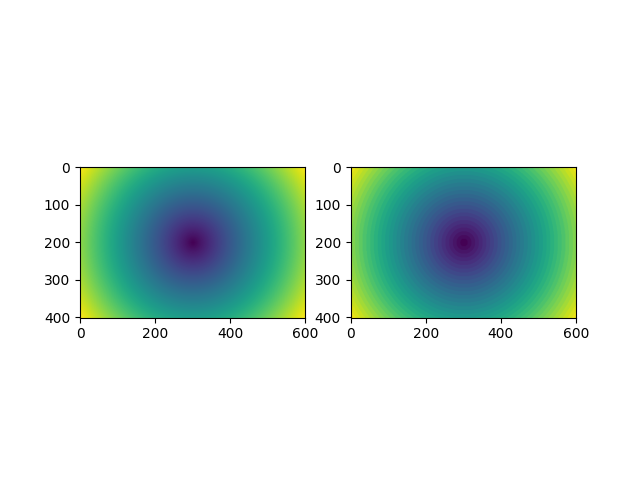

In [3]:
fig,ax = subplots(1, 2)
ax[0].imshow(r)
ax[1].imshow(qbin)

In [4]:
%%time
pixel_cnt = numpy.bincount(qbin.ravel())
mask_ptr = numpy.concatenate(([0], pixel_cnt.cumsum()))
nbins = qbin.max()+1
positions = numpy.arange(nbins)

CPU times: user 832 µs, sys: 334 µs, total: 1.17 ms
Wall time: 633 µs


In [5]:
%time
from scipy.sparse import csc_matrix
row = numpy.digitize(qbin.ravel(), positions)-1
size = row.size
col = numpy.arange(size)
dat = numpy.ones(size, dtype=float)
csc = csc_matrix((dat, (row, col)), shape = (nbins, size))
print(csc.shape)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
(37, 241001)


In [6]:
%time csr = csc.tocsr()

CPU times: user 3.88 ms, sys: 0 ns, total: 3.88 ms
Wall time: 2.7 ms


In [7]:
csr.indices

array([115087, 115088, 115089, ..., 240399, 240400, 241000], dtype=int32)

# Implement dense correlator in OpenCL...

In [8]:
nframes = 1000
stack = numpy.random.randint(0, 10, size = (nframes,)+shape).astype("uint8")

In [9]:
%load_ext pyopencl.ipython_ext
%load_ext line_profiler

In [10]:
import pyopencl  as cl
from pyopencl import array as cla

ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x55880ba23670>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x55880b9eceb8>
Choice [0]:
Choose device(s):
[0] <pyopencl.Device 'GeForce GTX TITAN' on 'NVIDIA CUDA' at 0x55880b64c6d0>
[1] <pyopencl.Device 'Quadro M2000' on 'NVIDIA CUDA' at 0x55880b7989f0>
Choice, comma-separated [0]:
Set the environment variable PYOPENCL_CTX=':' to avoid being asked again.


In [11]:
%%cl_kernel
/*Size if the kernel: dim0: qbin 
                      dim1: tau        
*/


kernel void correlator_multiQ_dense(
    const global char* frames,
    const global int* q_mask_ptr,
    const global int* q_mask_pixels,
    global float* output1,
    global float* output2,
    global int* outputc,
    const int Nt,
    const int image_size
) {
    uint qbin = get_global_id(0);
    uint tau = get_global_id(1);
    if (tau >= Nt) return;
    
    
    int pix_idx, denom_a, denom_b, cnt, num, num2, denom2_a, denom2_b;
    double denom, denom2, sum2, mean;
    const int start = q_mask_ptr[qbin+1];
    const int stop = q_mask_ptr[qbin+2];
    num = 0;
    num2 = 0;
    denom = 0.0f;
    denom2 = 0.0f;
    sum2 = 0.0f;
    cnt = 0;
    int npix = stop - start;
    for (int t = tau; t < Nt; t++) {
        num2 = 0;
        denom_a = 0;
        denom_b = 0;
        for (int idx = start; idx < stop; idx++) {
            pix_idx = q_mask_pixels[idx];
            uint val1 = frames[t*image_size + pix_idx];
            uint val2 = frames[(t-tau)*image_size + pix_idx];
            uint prod = val1*val2;
            num += prod;
            num2 += prod;
            denom_a +=val1;
            denom_b +=val2;
            cnt++;
        }
        denom += 1.0 * denom_a * denom_b;
        sum2 += pown(1.0 * num2 / (denom_a * denom_b), 2);
    }
    mean = 1.0 * npix * num / denom;
    output1[qbin*Nt + tau] = mean;
    output2[qbin*Nt + tau] = sqrt((npix*npix*sum2/(Nt-tau) - mean*mean)/(Nt-tau));
    outputc[qbin*Nt + tau] = cnt;
}


In [12]:
d_frames = cla.to_device(queue, stack)
d_q_mask_ptr = cla.to_device(queue, csr.indptr)
d_q_mask_pix = cla.to_device(queue, csr.indices)
d_out = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
d_out2 = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
d_outc = cla.zeros(queue, (nbins-1,nframes), dtype="int32")
t0 = time.perf_counter()
evt = correlator_multiQ_dense(queue, (nbins-1, (nframes+31)//32*32), (1,32),
                            d_frames.data,
                            d_q_mask_ptr.data,
                            d_q_mask_pix.data,
                            d_out.data,
                            d_out2.data,
                            d_outc.data,
                            numpy.int32(nframes),
                            numpy.int32(qbin.size))

In [13]:
evt.wait()
print(time.perf_counter()-t0)

32.01623377087526


In [14]:
d_out.get()[0]#-res[0][0]

array([1.4073063 , 0.999787  , 1.0001363 , 0.9995761 , 0.9999829 ,
       1.000238  , 1.0003966 , 1.0000248 , 1.0002103 , 0.9998898 ,
       1.0000869 , 0.99962085, 1.000177  , 0.9994807 , 1.000154  ,
       1.0009668 , 0.9999316 , 0.99969476, 1.000634  , 1.0004776 ,
       0.99904996, 0.99994385, 1.0002124 , 1.0005805 , 1.0003015 ,
       0.9999894 , 1.0004258 , 0.9999074 , 1.0001718 , 0.99982977,
       1.0003637 , 0.9998593 , 0.9995773 , 1.0004692 , 1.0006247 ,
       1.0007052 , 1.0002702 , 1.0001854 , 0.9996982 , 1.0005414 ,
       1.0002081 , 1.0003439 , 0.99991196, 0.99984646, 1.0002931 ,
       0.9993605 , 1.0000393 , 1.0002326 , 0.9999009 , 1.0006601 ,
       0.9995956 , 1.0003784 , 1.000737  , 0.99942756, 1.0001903 ,
       1.0000085 , 1.000302  , 1.00006   , 0.99970835, 1.0001485 ,
       1.0001141 , 1.0002813 , 1.0006037 , 0.99908483, 0.99989045,
       0.9996714 , 0.9995551 , 1.0003264 , 1.0002495 , 1.000417  ,
       0.9996958 , 1.0002962 , 0.9996214 , 1.0002245 , 1.00001

In [15]:
(evt.profile.end-evt.profile.start)*1e-9

32.015209472

In [16]:
from dynamix.correlator import dense

/users/kieffer/.venv/py39/lib/python3.9/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [17]:
d=dense.MatMulCorrelator(shape, nframes, qmask=qbin)

In [18]:
%time res = d.correlate(stack, calc_std=True)

CPU times: user 29.5 s, sys: 18.6 s, total: 48.1 s
Wall time: 5.35 s


In [19]:
# %lprun -f d.correlate res = d.correlate(stack, calc_std=True)

In [20]:
#  %lprun -f sys.modules[d.__module__].__getattribute__("py_dense_correlator") res = d.correlate(stack, calc_std=True)

<IPython.core.display.Javascript object>


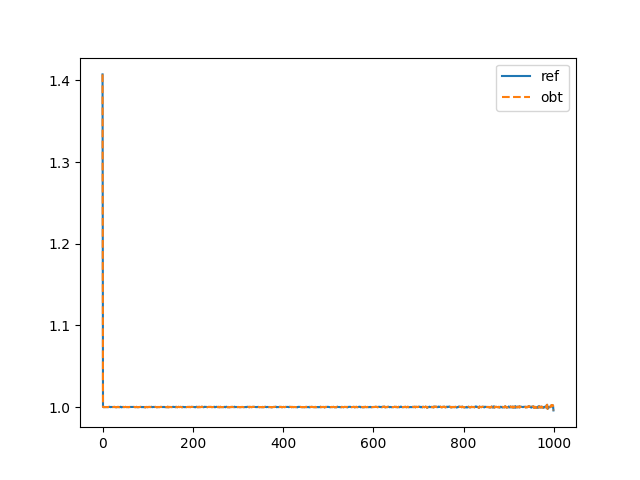

In [21]:
fig, ax = subplots()
bin = 16
ax.plot(res[0][bin], label="ref")
ax.plot(d_out.get()[bin], "--", label="obt")
ax.legend()

<IPython.core.display.Javascript object>


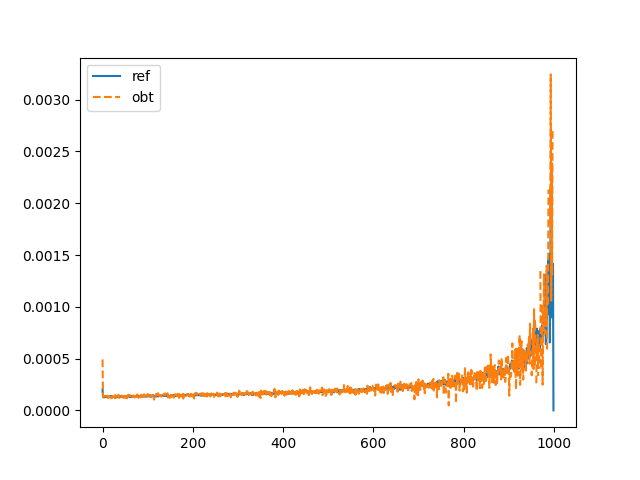

In [22]:
fig, ax = subplots()
bin = 14
ax.plot(res[1][bin], label="ref")
ax.plot(d_out2.get()[bin], "--", label="obt")
ax.legend()

In [23]:
X=numpy.random.random(1000)
l = len(X)
numpy.std(X)

0.279831954232558

In [24]:
res = numpy.sqrt(((X**2).sum()/(l)-(X.sum()/l)**2))
print(res, res-numpy.std(X))

0.2798319542325579 -1.1102230246251565e-16
